In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import tensorflow as tf
import numpy as np  
import matplotlib.pyplot as plt

import cv2
import PIL

from tensorflow.keras import Model

In [91]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  gram_matrix = tf.expand_dims(result, axis=0)
  input_shape = tf.shape(input_tensor)
  i_j = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return gram_matrix/i_j 

In [98]:
def load_model():
  vgg_model = tf.keras.applications.VGG19(include_top=True, weights=None)
  vgg_model.load_weights('/content/drive/MyDrive/NST/vgg19_weights_tf_dim_ordering_tf_kernels.h5')
  vgg_model.trainable = False
  content_layers = ['block5_conv2']
  style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
  content_op = vgg_model.get_layer(content_layers[0]).output 
  style_op = [vgg_model.get_layer(style_layer).output for style_layer in style_layers]
  gram_style_op = [gram_matrix(output_) for output_ in style_op]

  model = Model([vgg_model.input], [content_op, gram_style_op])
  return model

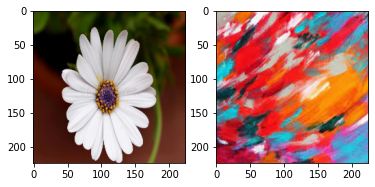

In [94]:
%matplotlib inline

content_image = cv2.resize(cv2.imread('/content/drive/MyDrive/NST/content2.jpg'), (224, 224))
content_image = tf.image.convert_image_dtype(content_image, tf.float32)
style_image = cv2.resize(cv2.imread('/content/drive/MyDrive/NST/style1.jpg'), (224, 224))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(np.array(content_image), cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(np.array(style_image), cv2.COLOR_BGR2RGB))
plt.show()

In [95]:
opt = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

In [96]:
def loss_object(style_outputs, content_outputs, style_target, content_target):
  style_weight = 1e-4
  content_weight = 1e-1
  content_loss = tf.reduce_mean((content_outputs - content_target)**2)
  style_loss = tf.add_n([tf.reduce_mean((output_ - target_)**2) for output_, target_ in zip(style_outputs, style_target)])
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss

In [99]:
vgg_model = load_model()
content_tar = vgg_model(np.array([content_image*255]))[0]
style_tar = vgg_model(np.array([style_image*255]))[1]

In [100]:
def train_step(image, epoch):
  with tf.GradientTape() as tape:
    output = vgg_model(image*255)
    loss = loss_object(output[1], output[0], style_tar, content_tar)
  gradient = tape.gradient(loss, image)
  opt.apply_gradients([(gradient, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

  if epoch % 5 ==0:
    tf.print(f"{epoch} Loss = {loss}")


In [101]:
EPOCHS = 100
STEPS = 10

image = tf.image.convert_image_dtype(content_image, tf.float32)
image = tf.Variable([image])
for i in range(EPOCHS):
  for m in range(STEPS):
    train_step(image, m)

0 Loss = 141388000.0
5 Loss = 98457752.0
0 Loss = 66393808.0
5 Loss = 44319696.0
0 Loss = 31189130.0
5 Loss = 23966636.0
0 Loss = 19680646.0
5 Loss = 16895138.0
0 Loss = 15354734.0
5 Loss = 14618923.0
0 Loss = 14131003.0
5 Loss = 13694041.0
0 Loss = 13193392.0
5 Loss = 12511283.0
0 Loss = 11724544.0
5 Loss = 10904675.0
0 Loss = 10089344.0
5 Loss = 9299356.0
0 Loss = 8548183.0
5 Loss = 7852948.0
0 Loss = 7234041.0
5 Loss = 6698033.0
0 Loss = 6233818.5
5 Loss = 5834090.5
0 Loss = 5491822.0
5 Loss = 5194694.0
0 Loss = 4929013.0
5 Loss = 4691571.0
0 Loss = 4481876.0
5 Loss = 4290614.0
0 Loss = 4108597.75
5 Loss = 3933638.75
0 Loss = 3766559.25
5 Loss = 3609349.25
0 Loss = 3461388.5
5 Loss = 3320955.0
0 Loss = 3189448.75
5 Loss = 3066489.75
0 Loss = 2952224.25
5 Loss = 2843072.0
0 Loss = 2738452.25
5 Loss = 2639068.0
0 Loss = 2544761.0
5 Loss = 2453830.75
0 Loss = 2367526.25
5 Loss = 2287861.25
0 Loss = 2213176.75
5 Loss = 2142349.75
0 Loss = 2074911.75
5 Loss = 2010829.25
0 Loss = 1950774.

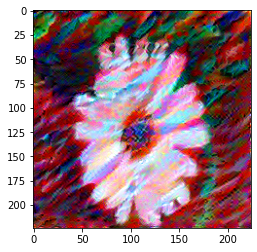

In [102]:
import PIL
arr = np.array(image*255, dtype=np.uint8)
if np.ndim(arr)>3:
  assert arr.shape[0] == 1
  arr = arr[0]
arr =  PIL.Image.fromarray(arr)
plt.imshow(cv2.cvtColor(np.array(arr), cv2.COLOR_BGR2RGB))
plt.show()